In [18]:
import fixed_income_derivatives_E2024 as fid
from numpy.linalg import solve, inv
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, root_scalar, minimize_scalar
from scipy.stats import norm, ncx2, gamma
import copy
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
import seaborn as sns

In [19]:
# Problem 3

EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate": 0.0430136}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.0455066},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.0477436},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.0497492},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.0515456},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.0531529},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.0545893},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.0558712},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.0570135},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.0580298}]
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.0558702, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.058811, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.0600937, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.0605263, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.0601899, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.0586669, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.0562267, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.0547351, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.0535523, "float_freq": "semiannual", "fixed_freq": "annual","indices": []}]
data = EURIBOR_fixing + fra_market + swap_market

mesh = 1/12
M = 360
T = np.array([mesh*i for i in range(0,M+1)])



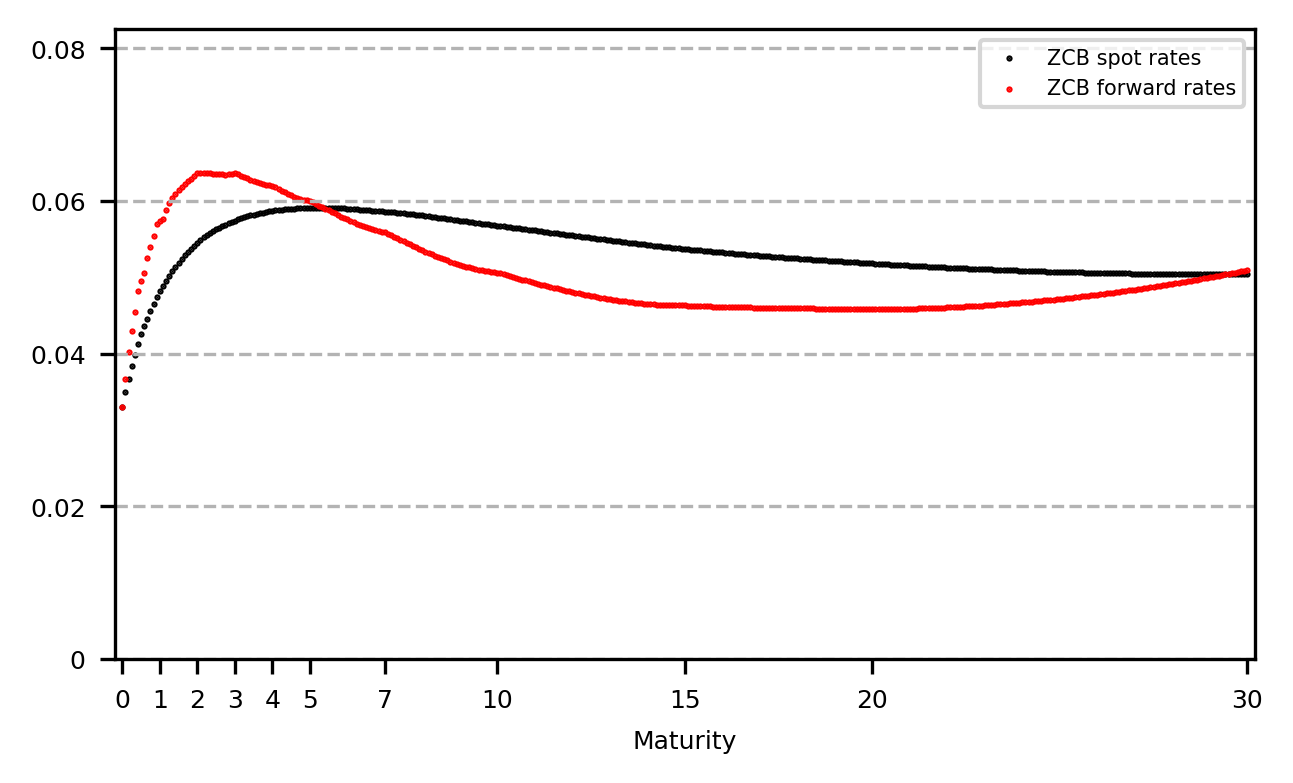

In [20]:
# 3a 
# Problem 3a - Fitting ZCB spot- and forward rate curves
# interpolation_options = {"method":"linear"}
# interpolation_options = {"method":"nelson_siegel","transition": "smooth"}
interpolation_options = {"method":"hermite","degree":2,"transition": "smooth"}
T_fit, R_fit = fid.zcb_curve_fit(data,interpolation_options = interpolation_options)
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T,T_fit,R_fit,interpolation_options = interpolation_options)

# Plotting 
fig = plt.figure(constrained_layout = False, dpi = 300, figsize = (5,3))
fig.suptitle(f"", fontsize = 10)
gs = fig.add_gridspec(nrows = 1, ncols = 1, left = 0.12, bottom = 0.2, right = 0.88, top = 0.90, wspace = 0, hspace = 0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([0,0.0825])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T, R_inter, s = 1, color = 'black', marker = ".",label="ZCB spot rates")
p2 = ax.scatter(T, f_inter, s = 1, color = 'red', marker = ".",label="ZCB forward rates")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
plt.show()

Parameters from the fit: [ 2.98664660e-02  6.90854843e+00  3.74629434e-01 -7.47801601e-08]. SSE of the fit: 0.0038250433633889576


/var/folders/dm/v2ztg7hn3_z54xvh868kqz300000gn/T/ipykernel_18437/2186826624.py:3: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(fid.fit_vasicek_obj,param_0,method = 'nelder-mead',args = (R_inter,T_inter),options={'xatol': 1e-20,'disp': True})


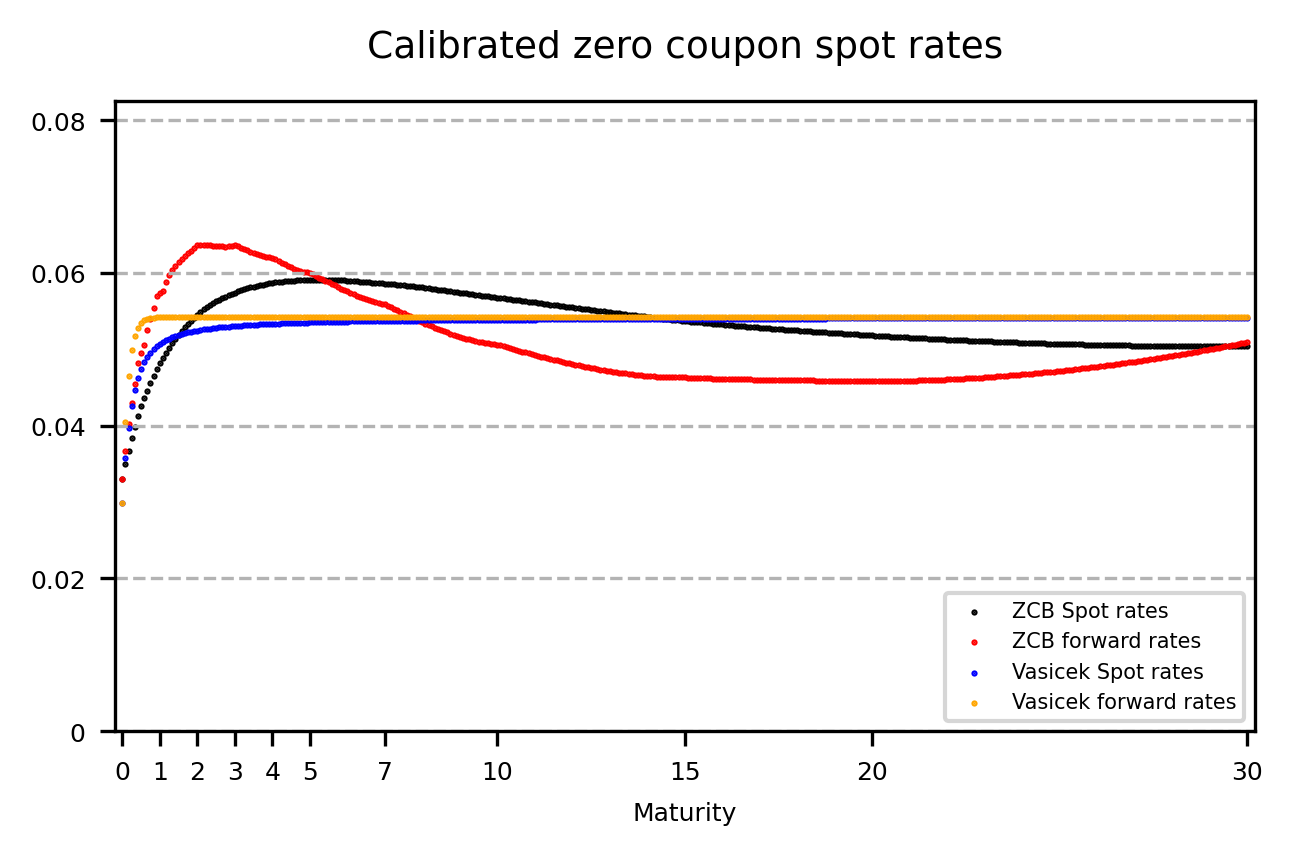

In [21]:
# Problem 3b - Fitting a Vasicek model to the yield curve
param_0 = 0.035, 0.5, 0.025, 0.03
result = minimize(fid.fit_vasicek_obj,param_0,method = 'nelder-mead',args = (R_inter,T_inter),options={'xatol': 1e-20,'disp': True})
print(f"Parameters from the fit: {result.x}. SSE of the fit: {result.fun}")
r0_vasicek, a_vasicek, b_vasicek, sigma_vasicek = result.x
p_vasicek = fid.zcb_price_vasicek(r0_vasicek,a_vasicek,b_vasicek,sigma_vasicek,T_inter)
f_vasicek = fid.forward_rate_vasicek(r0_vasicek,a_vasicek,b_vasicek,sigma_vasicek,T_inter)
R_vasicek = fid.spot_rate_vasicek(r0_vasicek,a_vasicek,b_vasicek,sigma_vasicek,T_inter)

fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated zero coupon spot rates", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([0,0.0825])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter, R_inter, s = 1, color = 'black', marker = ".",label="ZCB Spot rates")
p2 = ax.scatter(T_inter, f_inter, s = 1, color = 'red', marker = ".",label="ZCB forward rates")
p3 = ax.scatter(T_inter, R_vasicek, s = 1, color = 'blue', marker = ".",label="Vasicek Spot rates")
p4 = ax.scatter(T_inter, f_vasicek, s = 1, color = 'orange', marker = ".",label="Vasicek forward rates")
plots = [p1,p2,p3,p4]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 5)
plt.show()

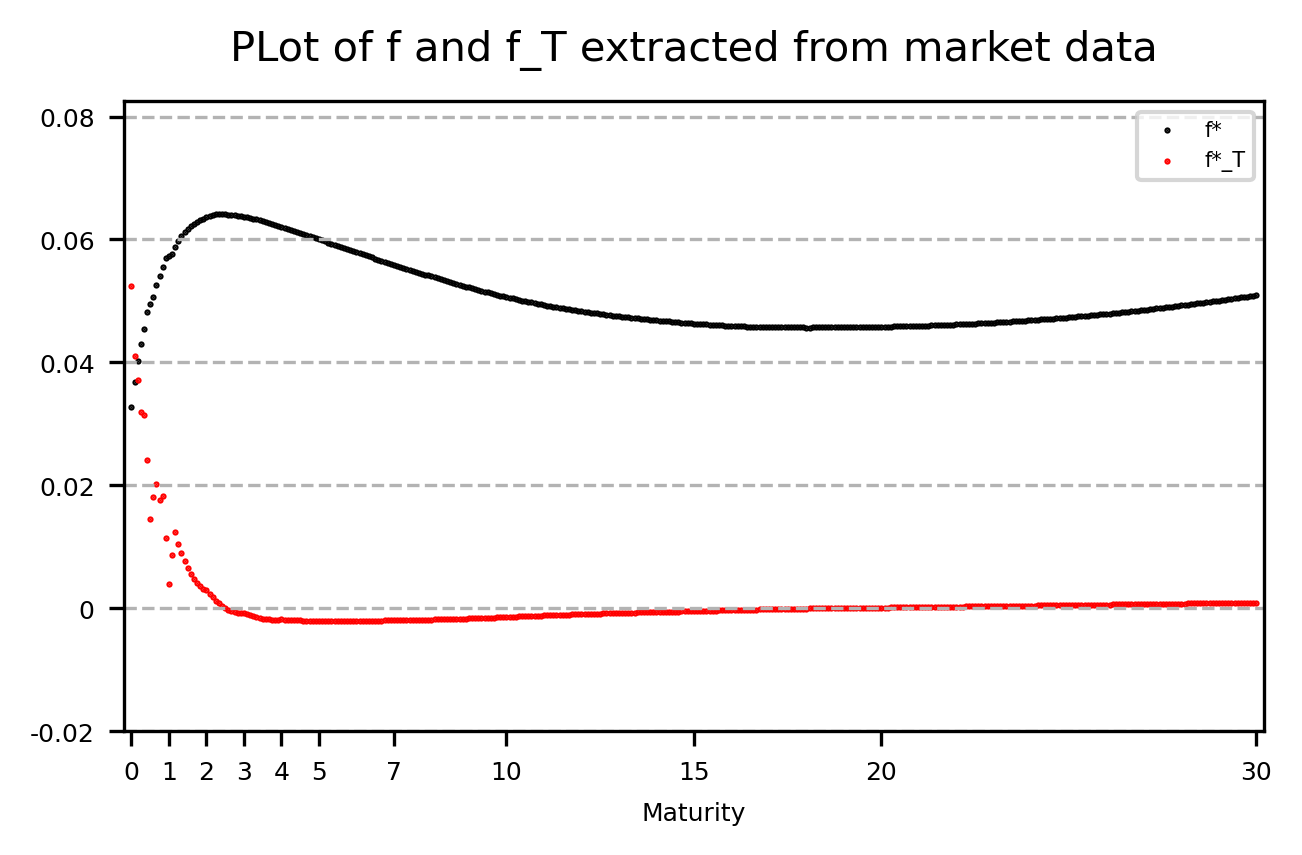

In [22]:
# Problem 4 - Fitting a Ho-Lee model to the data
T_star = np.array([mesh*i for i in range(0,M+1)])
f_fit = np.array(fid.for_values_in_list_find_value_return_value(T_fit,T_inter,f_inter))
f_star, f_T_star = fid.interpolate(T_star,T_fit,f_fit,interpolation_options)

fig = plt.figure(constrained_layout = False, dpi = 300, figsize = (5,3))
fig.suptitle(f"PLot of f and f_T extracted from market data", fontsize = 10)
gs = fig.add_gridspec(nrows = 1, ncols = 1, left = 0.12, bottom = 0.2, right = 0.88, top = 0.90, wspace = 0, hspace = 0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([-0.02,0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([-0.02,0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([-0.02,0.0825])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T, f_star, s = 1, color = 'black', marker = ".",label="f*")
p2 = ax.scatter(T, f_T_star, s = 1, color = 'red', marker = ".",label="f*_T")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
plt.show()

In [23]:
# Problem 5 - Pricing an interest rate cap
strike = 0.06
alpha = 0.5
T_cap = 10
sigma = 0.005
M_caplet = int(T_cap/alpha)
T_caplet = np.array([i*alpha for i in range(0,M_caplet+1)])
p_caplet = fid.for_values_in_list_find_value_return_value(T_caplet,T_inter,p_inter)
price_caplet = np.zeros([M_caplet+1])
for i in range(2,M_caplet+1):
    price_caplet[i] = (1 + (T_caplet[i]-T_caplet[i-1])*strike)*fid.euro_option_price_ho_lee(1/(1 + (T_caplet[i]-T_caplet[i-1])*strike),T_caplet[i-1],T_caplet[i],p_caplet[i-1],p_caplet[i],sigma,type = "put")
price_cap = sum(price_caplet[2:])
S_swap = fid.accrual_factor_from_zcb_prices(0,0,T_caplet[-1],"semiannual",T_caplet,p_caplet)
premium_cap = alpha*(price_cap/S_swap)
print(f"Caplet prices: {10000*price_caplet}")
print(f"price_cap: {10000*price_cap}, premium_cap: {10000*premium_cap}")
price_caplet_down = fid.caplet_prices_ho_lee(strike,sigma-0.001,T_caplet,p_caplet)
price_cap_down = sum(price_caplet_down[2:])
premium_cap_down = alpha*(price_cap_down/S_swap)
print(f"price_cap_down: {10000*price_cap_down}, premium_cap_down: {10000*premium_cap_down}")
price_caplet_up = fid.caplet_prices_ho_lee(strike,sigma+0.001,T_caplet,p_caplet)
price_cap_up = sum(price_caplet_up[2:])
premium_cap_up = alpha*(price_cap_up/S_swap)
print(f"price_cap_up: {10000*price_cap_up}, premium_cap_up: {10000*premium_cap_up}")

Caplet prices: [ 0.          0.          0.52217705 10.14982795 20.30600121 24.20758962
 24.16430027 23.93502108 21.79950697 20.207452   18.26879436 16.8417119
 14.65182409 13.1961444  12.57063401 11.74907576 10.37004954  9.32503641
  8.61267009  8.23137278  8.19191709]
price_cap: 277.3011065848026, premium_cap: 18.509084281117964
price_cap_down: 225.11549575802619, premium_cap_down: 15.02583864625412
price_cap_up: 331.2208801218389, premium_cap_up: 22.108080495403147


In [33]:
# Problem 6 - Simulation in the Ho-Lee model
M_simul, T_simul = 5000, 10
size_ci = 0.95
r0 = f_inter[0]
mesh_simul = T_simul/M_simul
t_simul = np.array([i*mesh_simul for i in range(0,M_simul+1)])
f_simul, f_T_simul = fid.interpolate(t_simul,T_fit,f_fit,interpolation_options)
np.random.seed(7)
r_simul_euler = fid.simul_ho_lee(r0,f_T_simul,sigma,T_simul,method = "euler")        # np.random.seed(7) is good, np.random.seed(4) increases, np.random.seed(3) declines
np.random.seed(7)
r_simul_exact = fid.simul_ho_lee(r0,f_T_simul,sigma,T_simul,method = "exact",f=f_simul)     # np.random.seed(1) is good
theta = fid.theta_ho_lee(t_simul,f_T_simul,sigma)
mean_ho_lee, var_ho_lee = fid.mean_var_ho_lee(f_simul,sigma,t_simul)
lb, ub = fid.ci_ho_lee(f_simul,sigma,t_simul,size_ci,type_ci = "two_sided")

In [46]:
# Problem 7 - Pricing a 1Y4Y receiver swaption
np.random.seed(15)
strike = 0.06
T_n, T_N, alpha = 1, 5, 0.5
M_simul_swaption, N_simul = 1000, 30
chi, price_swaption_simul, price_swaption_plot = np.zeros([N_simul]), np.zeros([N_simul]), np.zeros([N_simul])
mesh_simul_swaption = T_n/M_simul_swaption
t_swaption = np.array([i*mesh_simul_swaption for i in range(0,M_simul_swaption+1)])
f_swaption, f_T_swaption = fid.interpolate(t_swaption,T_fit,f_fit,interpolation_options)
f_t = fid.for_values_in_list_find_value_return_value(T_n,T_star,f_star)
T_swaption = np.array([i*alpha for i in range(int(T_n/alpha),int(T_N/alpha)+1)])
p_swaption = fid.zcb_price_ho_lee(T_n,T_swaption,0,sigma,T_inter,p_inter,f_t)
T_swap = np.array([i*alpha for i in range(0,int((T_N-T_n)/alpha)+1)])
for i in range(0,N_simul):
    r_simul_swaption = fid.simul_ho_lee(r0,f_T_swaption,sigma,T_n,method = "euler",seed = None)
    p_swap = p_swaption.copy()
    for j, T_j in enumerate(T_swaption):
        p_swap[j] = p_swaption[j]*np.exp(-(T_swaption[j]-T_n)*r_simul_swaption[-1])
    R_swap, S_swap = fid.swap_rate_from_zcb_prices(0,0,T_N-T_n,"semiannual",T_swap,p_swap)
    chi[i] = max(strike-R_swap,0)*S_swap
    price_swaption_simul[i] = np.exp(-(T_n/M_simul_swaption)*sum(r_simul_swaption))*chi[i]
    price_swaption_plot[i] = sum(price_swaption_simul[0:i+1])/(i+1)*10000
print(f"price_swaption: {price_swaption_plot[-1]}")


price_swaption: 14.934669641149867


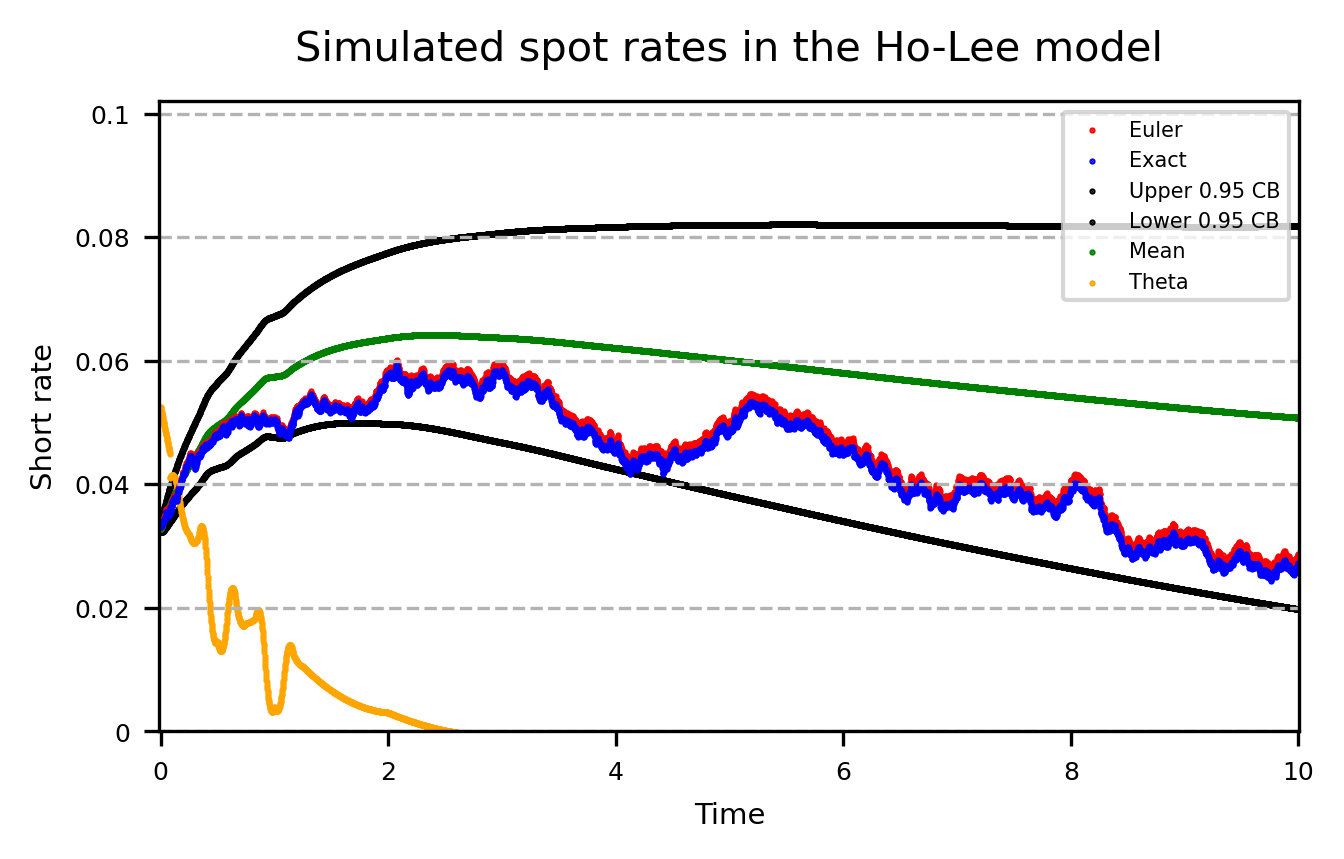

In [ ]:
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Simulated spot rates in the Ho-Lee model",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.01,xticks[-1]+0.01])
plt.xlabel(f"Time",fontsize = 7)
yticks1 = [0,0.02,0.04,0.06,0.08,0.1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Short rate",fontsize = 7)
p3 = ax.scatter(t_simul, ub, s = 1, color = 'black', marker = ".",label=f"Upper {size_ci} CB")
p4 = ax.scatter(t_simul, lb, s = 1, color = 'black', marker = ".",label=f"Lower {size_ci} CB")
p5 = ax.scatter(t_simul, mean_ho_lee, s = 1, color = 'green', marker = ".",label=f"Mean")
p6 = ax.scatter(t_simul, theta, s = 1, color = 'orange', marker = ".",label=f"Theta")
p1 = ax.scatter(t_simul, r_simul_euler, s = 1, color = 'red', marker = ".",label="Euler")
p2 = ax.scatter(t_simul, r_simul_exact, s = 1, color = 'blue', marker = ".",label="Exact")
plots = [p1,p2,p3,p4,p5,p6]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
plt.show()